## 1. Make classification data and get it ready

In [31]:
from sklearn.datasets import make_circles

n_samples = 1000

# create circles
X, y= make_circles(n_samples, noise= 0.03, random_state=42)

print('Shape of x:',X.shape) # 1000 rows and 2 columns(columns represent coordinates of labels(y))
print('Shape of y:', y.shape) # 1000 levels(0 or 1) for each row

Shape of x: (1000, 2)
Shape of y: (1000,)


In [32]:
X[0:5,0]

array([ 0.75424625, -0.75615888, -0.81539193, -0.39373073,  0.44220765])

noise = 0.03:
What It Did:

It scattered the points a little around their ideal circle positions.

So instead of razor-sharp circles, you now have fuzzy boundaries where points overlap slightly.

This makes the classification task non-trivial — the model has to learn decision boundaries rather than memorizing perfect geometry.

In [33]:
# check first 5 fetures and labels
print(f"X features: {X[:5]} \n y labels: {y[:5]}")

X features: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 
 y labels: [1 1 1 1 0]


In [34]:
# make dataframe of circles data
import pandas as pd
circles = pd.DataFrame({'X1': X[:,0],
                        'X2':X[:,1],
                        'label':y})
circles.head(5) # first 5 rows of each column

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [35]:
# it binary classification problem
# check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


Insights: Labels are uniformally distributed => model will be unbiased

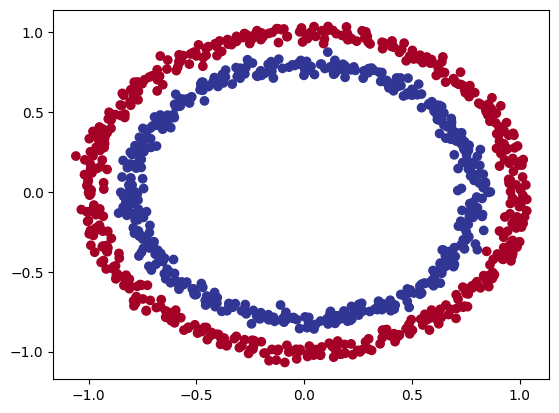

In [36]:
# visualization
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

Explanation:

1. x=X[:,0] and y=X[:,1]
Plot the x-coordinates (X[:,0]) on the horizontal axis.

Plot the y-coordinates (X[:,1]) on the vertical axis.

Each row of X becomes one point in the scatter plot.

2. c=y
The c parameter controls the color of each point.

Here, y is the label array (0 or 1).

So:

Points with label 0 → one color(Inner circle).

Points with label 1 → another color(Outer circle).

It does not mean “yellow” specifically. It means “use the values in y to assign colors.”

3. cmap=plt.cm.RdYlBu
cmap stands for colormap.

plt.cm.RdYlBu is a predefined colormap in Matplotlib:

Rd = Red

Yl = Yellow

Bu = Blue

It’s a gradient that goes from red → yellow → blue.

Since y only has two values (0 and 1), Matplotlib picks two distinct colors from this gradient (e.g., red for 0, blue for 1).

What You See in the Plot
Inner circle points (label = 0) → one color (say, red).

Outer circle points (label = 1) → another color (say, blue).

The colormap defines which colors are chosen, but y itself is just the class label, not a color name.

## 1.2 Turn data into tensors and create train and test splits

In [37]:
# turn data into tensors otherwise this causes issues with computations later on
import torch
X= torch.from_numpy(X).type(torch.float32)
y= torch.from_numpy(y).type(torch.float32)
# torch.from_numpy(X) converts a NumPy array into a PyTorch tensor.
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [38]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,
    test_size= 0.2, random_state= 42)
print(X_train[0:5,0:2],"\n",y_train[:5]) #Remember it is a tensor not a Dataframe


tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]]) 
 tensor([1., 0., 0., 0., 1.])


In [39]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [40]:
import torch
import torch.nn as nn

device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [41]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # create 2 nn.Linear layers capable of handling X and y input and output
    self.layer_1= nn.Linear(in_features=2, out_features=5) # takes in 2(2 neurons) features (X), produces 5(5 neurons) features
    self.layer_2= nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

  # define a forward method containing the forward pass computation
  def forward(self,x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2
    # if more than 2 layers then: return self.layer_3(self.layer_2(self.layer_1(x)))

# create an instance of the model and send it to target device
model_0= CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Explanation:

in_features=2 → the layer expects 2 input neurons (because each data point has 2 values: X1 and X2).

out_features=5 → the layer produces 5 output neurons (a hidden representation of the input).

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features

In [42]:
# replicate CircleModelV0 with nn.Sequential
model_0= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Explanation:

What nn.Sequential() Does
nn.Sequential is a container that lets you stack layers one after another in the order you define.

Instead of writing a custom forward() method, PyTorch automatically passes the input through each layer sequentially.

🎯 Why We Use It
Simplifies code: You don’t need to subclass nn.Module or write a forward() method if your model is just a straight chain of layers.

Cleaner syntax: Perfect for simple feed-forward networks (like your CircleModelV0).

Quick prototyping: Great when you want to test architectures fast without boilerplate.

🖼️ Analogy
Think of it like this:

forward() → you write the recipe step by step yourself.

nn.Sequential() → you just list the ingredients in order, and PyTorch cooks them automatically.

👉 In short:
If you’ve already defined forward(), you don’t need nn.Sequential() for that model. nn.Sequential() is just a cleaner shortcut for simple architectures.

In [43]:
# Make prediction with the model
untrained_preds= model_0(X_test.to(device))
print(f"length of prediction: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"length of test sample: {len(y_test)}, shape: {y_test.shape}")
print(f"\n first 10 predcitions: \n {untrained_preds[:10]}")
print(f"\n first 10 test labels: \n {y_test[:10]}")



length of prediction: 200, shape: torch.Size([200, 1])
length of test sample: 200, shape: torch.Size([200])

 first 10 predcitions: 
 tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853],
        [0.1785],
        [0.2280],
        [0.1960],
        [0.2965],
        [0.3120]], grad_fn=<SliceBackward0>)

 first 10 test labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer

different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.


##Loss function/Optimizer:	Problem type:	PyTorch Code


Stochastic Gradient Descent (SGD) optimizer: Classification, regression, many others:	torch.optim.SGD()


Adam Optimizer:	Classification regression, many others: 	torch.optim.Adam()


Binary cross entropy loss:	Binary classification:	torch.nn.BCELossWithLogits or torch.nn.BCELoss


Cross entropy loss:	Multi-class classification:	torch.nn.CrossEntropyLoss


Mean absolute error (MAE) or L1 Loss:	Regression:	torch.nn.L1Loss


Mean squared error (MSE) or L2 Loss:	Regression:	torch.nn.MSELoss


## PyTorch has two binary cross entropy implementations:

torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).

In [44]:
# create a loss function
loss_fn= nn.BCEWithLogitsLoss() # BCEWithLogitsLoss= Sigmoid built-in

# create an optimizer
optimizer= torch.optim.SGD(params= model_0.parameters(),lr=0.1)

In [45]:
print(loss_fn)

BCEWithLogitsLoss()


In [46]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

In [47]:
# calculate accuracy(a classification metric)
def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc= (correct / len(y_pred))*100
  return acc

## 3. Train model

In [48]:
# view the first 5 outputs of the forward pass on the test data
y_logits= model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853]], grad_fn=<SliceBackward0>)

Which implements two layers of nn.Linear() which internally calls the following equation:

$$ \mathbf{y} = x \cdot \mathbf{Weights}^T + \mathbf{bias} $$

The raw outputs (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid

In [49]:
# use sigmoid on model logits
y_pred_probs= torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5809],
        [0.5779],
        [0.5725],
        [0.5834],
        [0.5462]], grad_fn=<SigmoidBackward0>)

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.


In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)
If y_pred_probs < 0.5, y=0 (class 0)
To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [50]:
# find the predicted labels(round the predictions probabilities)
y_preds= torch.round(y_pred_probs)
print("y_preds befor squeeze():",y_preds)
# in full
y_pred_labels= torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
print("y_preds:",y_preds.squeeze())

y_preds befor squeeze(): tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)
tensor([True, True, True, True, True])
y_preds: tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)


When you make predictions with your model:

python_code:
y_pred_probs = model_0(X_test.to(device))

The output shape is often (batch_size, 1) because the final layer has out_features=1.

After rounding:

python_code:
y_preds = torch.round(y_pred_probs)
the shape is still (batch_size, 1).

But your labels y_test usually have shape (batch_size,).
So to compare them properly, you use:

python_code:
y_preds.squeeze()
which changes (batch_size, 1) → (batch_size,).

## Note:
The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function .

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

## 3.2 Building a training and testing loop

In [51]:
torch.manual_seed(42)

epochs=100

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
  # trainin
  model_0.train()

  # 1. forward pass(model outputs raw logits)
  y_logits= model_0(X_train).squeeze() ## squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
  y_pred= torch.round(torch.sigmoid(y_logits)) ## turn logits -> pred probs -> pred labls

  # calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
  loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                 y_train)
  acc= accuracy_fn(y_true= y_train, y_pred= y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backword
  loss.backward()

  # optimizer step
  optimizer.step()

  # testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits= model_0(X_test).squeeze()
    test_pred= torch.round(torch.sigmoid(test_logits))

    # calculate loss/accuracy
    test_loss= loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true= y_test, y_pred= test_pred)

  # print out what's every 10 epochs
  if epoch%10==0:
    print(f"Epoch: {epoch} | Loss:{loss:.4f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc:{test_acc:.2f}%")

Epoch: 0 | Loss:0.7017, Accuracy: 50.00% | Test loss: 0.70198, Test acc:50.00%
Epoch: 10 | Loss:0.6975, Accuracy: 50.00% | Test loss: 0.69785, Test acc:50.00%
Epoch: 20 | Loss:0.6954, Accuracy: 50.00% | Test loss: 0.69580, Test acc:50.00%
Epoch: 30 | Loss:0.6944, Accuracy: 50.50% | Test loss: 0.69477, Test acc:50.50%
Epoch: 40 | Loss:0.6939, Accuracy: 57.38% | Test loss: 0.69425, Test acc:54.50%
Epoch: 50 | Loss:0.6936, Accuracy: 53.00% | Test loss: 0.69397, Test acc:53.00%
Epoch: 60 | Loss:0.6934, Accuracy: 52.12% | Test loss: 0.69383, Test acc:54.00%
Epoch: 70 | Loss:0.6933, Accuracy: 51.38% | Test loss: 0.69375, Test acc:51.50%
Epoch: 80 | Loss:0.6932, Accuracy: 51.38% | Test loss: 0.69371, Test acc:52.00%
Epoch: 90 | Loss:0.6932, Accuracy: 51.50% | Test loss: 0.69369, Test acc:51.50%


## 4. make predictions and evaluate the model

In [52]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


🔎 What helper_functions.py Is
It’s just a Python file that contains some extra utility functions (like small tools) written by the course author.
Instead of you writing plotting code again and again, they gave you a ready-made file with functions inside.

🎯 What It Does in Your Case
Inside helper_functions.py, there are functions like:

plot_predictions → draws a graph comparing your model’s predictions vs the actual data points.

plot_decision_boundary → shows how your model separates two classes (like inner circle vs outer circle) on a 2D plot.

So basically, it’s a toolbox for visualization.

✅ Why You Need It
PyTorch itself doesn’t have built-in plotting functions.

Instead of writing long matplotlib code every time, you just call:

python_code:
plot_predictions(...)
plot_decision_boundary(...)

This makes your experiments easier to understand visually.

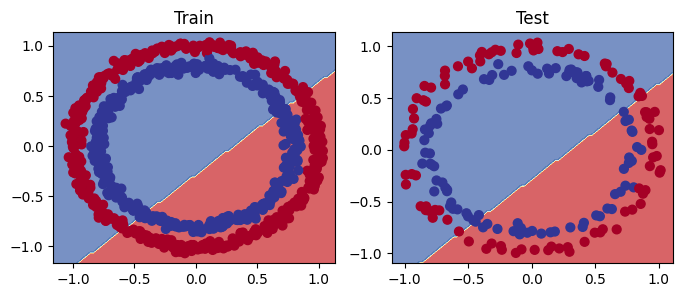

In [53]:
# plot decision boundaries for training and test sets
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Insights: We can see clearly in images this model is capable of predicting only 50 % of data using a straight line . For increases accuracy we need a non-linear function because data is non-linear.

## 6. For increasing the accuracy lets introduce NON-LINEARITY

 ## 6.2 Building a model with non-linearity

In [54]:
# Building model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1= nn.Linear(in_features=2, out_features=10)
    self.layer_2= nn.Linear(in_features=10, out_features=10)
    self.layer_3= nn.Linear(in_features=10, out_features=1)
    self.relu= nn.ReLU()
    # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


## Expalnation:
 Should layer_3 also be inside ReLU?
No — not usually.  
Here’s why:

The last layer is meant to produce raw outputs (called logits) that represent class scores.

If you apply ReLU after the last layer:

All negative logits would be squashed to 0.

That destroys useful information (e.g., one class might need a negative score to indicate “less likely”).

It also breaks loss functions like nn.CrossEntropyLoss or nn.BCEWithLogitsLoss, which expect raw logits (positive and negative values).

So the final layer is usually left without ReLU.

Now we've got a model ready to go, let's create a binary classification loss function as well as an optimizer.

In [55]:
# setup loss and optimizer
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(model_3.parameters(), lr= 0.1)

## 6.3 Training a model with non-linearity

In [58]:
torch.manual_seed(42)
epochs= 1000

# put all data on target device
X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # 1. forward pass
  y_logits= model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. calculate loss and accuracy
  loss= loss_fn(y_logits, y_train) # # BCEWithLogitsLoss calculates loss using logits
  acc= accuracy_fn(y_true= y_train,y_pred= y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  # model.eval() is needed to turn off training-specific behaviors (like dropout and batchnorm updates)
     # so your test results are stable and reflect the true performance of the model.
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred= torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss and accuracy
    test_loss= loss_fn(test_logits, y_test)
    test_acc= accuracy_fn(y_true= y_test, y_pred= test_pred)

  # print out what's happening
  if epoch % 100==0:
    print(f"Epoch:{epoch} | Loss: {loss:.6}, accuravy: {acc:.2f}, | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch:0 | Loss: 0.0417601, accuravy: 99.88, | Test Loss: 0.06583, Test Accuracy: 100.00%
Epoch:100 | Loss: 0.0362775, accuravy: 99.88, | Test Loss: 0.05979, Test Accuracy: 100.00%
Epoch:200 | Loss: 0.0320461, accuravy: 99.88, | Test Loss: 0.05460, Test Accuracy: 100.00%
Epoch:300 | Loss: 0.0287187, accuravy: 99.88, | Test Loss: 0.05022, Test Accuracy: 100.00%
Epoch:400 | Loss: 0.0260411, accuravy: 99.88, | Test Loss: 0.04662, Test Accuracy: 100.00%
Epoch:500 | Loss: 0.0238308, accuravy: 99.88, | Test Loss: 0.04363, Test Accuracy: 100.00%
Epoch:600 | Loss: 0.0219564, accuravy: 99.88, | Test Loss: 0.04091, Test Accuracy: 100.00%
Epoch:700 | Loss: 0.0203589, accuravy: 99.88, | Test Loss: 0.03864, Test Accuracy: 100.00%
Epoch:800 | Loss: 0.0189773, accuravy: 99.88, | Test Loss: 0.03680, Test Accuracy: 100.00%
Epoch:900 | Loss: 0.0177756, accuravy: 99.88, | Test Loss: 0.03512, Test Accuracy: 100.00%


## Achievement: I got significant accuracy.